# Configuração Inicial 

In [1]:
import pathlib
import sys

requirements_filename = 'requirements_ap4.txt'
if str(pathlib.Path().resolve().name) == "notebooks":
    root = str(pathlib.Path().resolve().parent.parent)+'/'
    sys.path.append(root)
    requirements_path = root + 'requirements/'+requirements_filename
else:
    ! git clone --branch ap4 https://github.com/Fabio-Trindade/Eng-Aprendizado-Maquina.git
    root = str(pathlib.Path().resolve())
    src_path = root + '/Eng-Aprendizado-Maquina/'
    requirements_path = src_path + 'requirements/'+requirements_filename
    sys.path.append(root + '/Eng-Aprendizado-Maquina/')

! pip install -r $requirements_path

# Imports

In [2]:
from src.utils.util_read_file import UtilReadFile
import pandas as pd
from sklearn.model_selection import train_test_split
from src.utils.util_pre_processor import UtilPreProcessor
import torch
from src.transforms.to_torch_tensor import NumpyToTorchTensor
import numpy as np
from src.utils.util_read_file import UtilReadFile
from src.utils.util_path import UtilPath

# Visualização dos Dados

In [3]:
root = UtilPath.get_root_path()
df = UtilReadFile.read_csv_with_pandas(root+'/datasets/spam-datasset.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
df.Category.unique().tolist()

['ham', 'spam']

## Analisando mensagens de SPAM

In [5]:
pd.set_option('display.max_colwidth', None)
# Descomente abaixo para visualizar todas as linhas
# pd.set_option('display.max_rows', None)
df[df.Category == 'spam']

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414 now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800
5547,spam,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records."
5566,spam,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode"


Ao analisar as mensagens de SPAM, foi possível perceber que muitas delas contém palavras maiúsculas, as palavras *call* e *ring*, números de telefone e dinheiro. Será analisado se esse comportamento se repete ou não em mensagens não SPAM.

## Analisando mensagens *ham*

In [6]:
pd.set_option('display.max_colwidth', None)
# Descomente abaixo para visualizar todas as linhas
# pd.set_option('display.max_rows', None)
df[df.Category == 'ham']

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
...,...,...
5565,ham,Huh y lei...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


As mensagens de não spam também contém as mesmas características observadas nas mensagens de SPAM, no entanto, parece ser com menos frequência.

## Análise e Pré-processamento

### Contando a quantidade de palavras maiúsculas

In [7]:
import re

def count_uppercase_words(message):
    uppercase_words = re.findall(r'\b[A-Z]{2,}\b', message)
    return len(uppercase_words) if  len(uppercase_words) < 10 else 10

df['count_uppercase'] = df['Message'].apply(count_uppercase_words)

<Axes: xlabel='count_uppercase'>

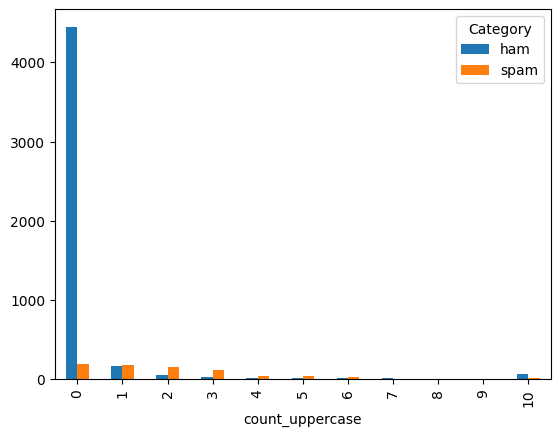

In [8]:
pivoted_df = df.pivot_table(index='count_uppercase', columns='Category', aggfunc='size', fill_value=0)
pivoted_df.plot(kind='bar')

O gráfico acima apresenta a quantidade de palavras com letras maiúsculas com mais de 1 letra agrupadas em mesnagens de spam e não spam. Vale ressaltar que, mensagens com 10 ou mais palavras deste tipo contam como 10 palavras.
 
A partir deste gráfico percebe-se que conforme a quantidade destas palavras na mensagem do texto aumenta, a chance dela ser não spam diminui extremamente. Textos que contém entre 2 e 9 palavras desse tipo serão agrupados em uma categoria (2), pois há uma maior chance de ser spam, enquanto mensagens com 10 ou mais palavras em maiúsculas serão agrupadas em outra categoria (3).

In [9]:
import re

def count_uppercase_words(message):
    uppercase_words = re.findall(r'\b[A-Z]{2,}\b', message)
    len_uppercase = len(uppercase_words)
    return  len_uppercase if len_uppercase < 2 else 3 if len_uppercase >= 10 else 2

df['count_uppercase'] = df['Message'].apply(count_uppercase_words)

<Axes: xlabel='count_uppercase'>

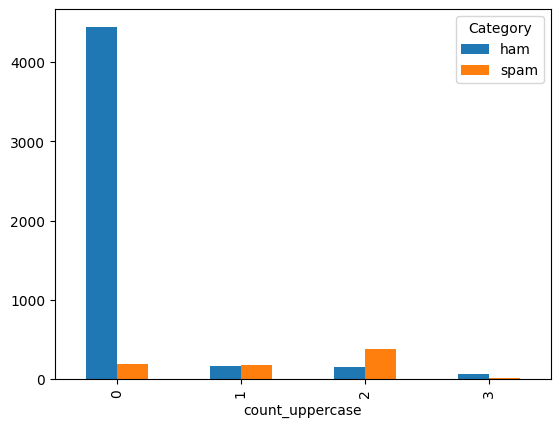

In [10]:
pivoted_df = df.pivot_table(index='count_uppercase', columns='Category', aggfunc='size', fill_value=0)

pivoted_df.plot(kind='bar')

### Tranformação de número de telefone em token
Como mensagens de spam contém muitos números de telefones, os mesmos serão substituídos por um texto TELEPHONE_NUMBER. Foi utilizado como critério textos que contenham uma sequência de 8 ou mais digítos.

In [11]:
pattern = r'\d{8,}\b'
df['Message'] = df['Message'].str.replace(pattern, 'TELEPHONE_NUMBER', regex=True)

In [12]:
df[df.Category == 'spam']

,Category,Message,count_uppercase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,2
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",0
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call TELEPHONE_NUMBER. Claim code KL341. Valid 12 hours only.,1
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on TELEPHONE_NUMBER,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",2
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring TELEPHONE_NUMBER now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,2
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,3
5547,spam,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",2
5566,spam,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",2


### Transformação de dinheiros em tokens
Como mensagens de spams citam muito palavras do tipo '£250' ou '2.50 pounds', estas serão substituídas por MONEY.

In [13]:
df[df.Category == 'spam']

,Category,Message,count_uppercase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,2
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",0
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call TELEPHONE_NUMBER. Claim code KL341. Valid 12 hours only.,1
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on TELEPHONE_NUMBER,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",2
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring TELEPHONE_NUMBER now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,2
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O £250 3 WANT £800,3
5547,spam,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",2
5566,spam,"REMINDER FROM O2: To get 2.50 pounds free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",2


In [14]:
pattern1 = r'\£\S+\b'
df['Message'] = df['Message'].str.replace(pattern1, ' MONEY ', regex=True)

In [15]:
pattern2 = r' \d\S* (pound|pounds) '
df['Message'] = df['Message'].str.replace(pattern2, ' MONEY ', regex=True)

In [16]:
df[df.Category == 'spam']

,Category,Message,count_uppercase
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,2
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, MONEY to rcv",0
8,spam,WINNER!! As a valued network customer you have been selected to receivea MONEY prize reward! To claim call TELEPHONE_NUMBER. Claim code KL341. Valid 12 hours only.,1
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on TELEPHONE_NUMBER,1
11,spam,"SIX chances to win CASH! From 100 to MONEY txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",2
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring TELEPHONE_NUMBER now! Costs 20p/min Gsex POBOX 2667 WC1N 3XX,2
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE MINS. INDIA CUST SERVs SED YES. L8ER GOT MEGA BILL. 3 DONT GIV A SHIT. BAILIFF DUE IN DAYS. I O MONEY 3 WANT MONEY,3
5547,spam,"Had your contract mobile 11 Mnths? Latest Motorola, Nokia etc. all FREE! Double Mins & Text on Orange tariffs. TEXT YES for callback, no to remove from records.",2
5566,spam,"REMINDER FROM O2: To get MONEY free call credit and details of great offers pls reply 2 this text with your valid name, house no and postcode",2


### Pré-processamento com NLTK

#### Instalando bibliotecas necessárias para o pré-processamento

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/fabio/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Gerando os tokens

In [18]:
df['Tokens'] = df['Message'].apply(word_tokenize)

In [19]:
df.head(2)

,Category,Message,count_uppercase,Tokens
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,"[Go, until, jurong, point, ,, crazy, .., Available, only, in, bugis, n, great, world, la, e, buffet, ..., Cine, there, got, amore, wat, ...]"
1,ham,Ok lar... Joking wif u oni...,0,"[Ok, lar, ..., Joking, wif, u, oni, ...]"


#### Retirando *stop_words* e pontuações

In [20]:
import string

df['Tokens'] = df['Tokens'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x if word.lower() not in stop_words])

In [21]:
df['Tokens'] = df['Tokens'].apply(lambda x: [word for word in x if word.isalnum()])

In [22]:
df

,Category,Message,count_uppercase,Tokens
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,"[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]"
1,ham,Ok lar... Joking wif u oni...,0,"[Ok, lar, Joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,2,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receive, entry, question, std, txt, rate, C, s, apply, 08452810075over18, s]"
3,ham,U dun say so early hor... U c already then say...,0,"[U, dun, say, early, hor, U, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives around here though",0,"[Nah, nt, think, goes, usf, lives, around, though]"
...,...,...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the MONEY Pound prize. 2 claim is easy, call TELEPHONE_NUMBER NOW1! Only 10p per minute. BT-national-rate.",1,"[2nd, time, tried, 2, contact, u, U, MONEY, Pound, prize, 2, claim, easy, call, TELEPHONENUMBER, NOW1, 10p, per, minute, BTnationalrate]"
5568,ham,Will ü b going to esplanade fr home?,0,"[ü, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other suggestions?",0,"[Pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,0,"[guy, bitching, acted, like, d, interested, buying, something, else, next, week, gave, us, free]"


### Transformando atributos em *bag of words*

In [23]:
from collections import Counter
from src.utils.util_pre_processor import UtilPreProcessor

vocab = set([word for doc in  df.Tokens.to_list() for word in doc])
bag_of_words = []
def generate_bag(tokens):
    doc = Counter(tokens)
    features_vector = []
    for word in vocab:
        features_vector.append(doc[word])
    return features_vector
    
df['bag'] = df['Tokens'].apply(generate_bag)


In [24]:
df.head(2)

,Category,Message,count_uppercase,Tokens,bag
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,"[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,ham,Ok lar... Joking wif u oni...,0,"[Ok, lar, Joking, wif, u, oni]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


### Transformando labels em vetores

Para se ajeitar a loss que será utilizada, os labels foram transformados em vetores de tamanho 2, onde [1,0] representa o label 0 (ham) e [0,1] representa o label 1 (spam).

In [25]:
df['category_label'],index = df.Category.factorize()
print(index)
def transform_category(value):
    if value == 0:
        return [1,0]
    elif value == 1:
        return [0,1]
    else:
        raise ValueError('Erro')
df['category_label'] = df['category_label'].apply(transform_category)


Index(['ham', 'spam'], dtype='object')


In [26]:
df.head(3)

,Category,Message,count_uppercase,Tokens,bag,category_label
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,"[Go, jurong, point, crazy, Available, bugis, n, great, world, la, e, buffet, Cine, got, amore, wat]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 0]"
1,ham,Ok lar... Joking wif u oni...,0,"[Ok, lar, Joking, wif, u, oni]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 0]"
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,2,"[Free, entry, 2, wkly, comp, win, FA, Cup, final, tkts, 21st, May, 2005, Text, FA, 87121, receive, entry, question, std, txt, rate, C, s, apply, 08452810075over18, s]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 1]"


## Treinamento

### Separação das features e labels

In [27]:
features = df[['count_uppercase','bag']]
labels = df['category_label']

### Separação dos dados em treino, teste e valdação

In [28]:
train_feat, test_feat, train_label, test_label = train_test_split(features, labels, test_size=0.2, random_state=42)

train_feat, valid_feat, train_label, valid_label  = train_test_split(train_feat, train_label, test_size=0.10, random_state=42)

### Criação do Modelo

O modelo utilizado para classificação das mensagens é uma rede *Perceptron*.

In [29]:
from src.models.mlp import MLP
dim_features = len(vocab) + 1

model = MLP([dim_features,2])
optimizer = torch.optim.Adam(list(model.parameters()))
loss_fn = torch.nn.CrossEntropyLoss()

### Loop de Treinamento

In [30]:
transform = NumpyToTorchTensor(dtype=float)
epochs = 5
for epoch in range(epochs):
    model.train()
    for (count,bag),label in zip(train_feat.values,train_label.values):
        optimizer.zero_grad()
        feat = transform(np.concatenate((np.array([count]),bag)))
        label = transform(np.array(label))
        predictions = torch.softmax(model(feat),dim=0)
        loss = loss_fn(predictions,label)
        loss.backward()
        optimizer.step()
    model.eval()
    correct = 0
    for (count,bag),label in zip(valid_feat.values,valid_label.values):
        feat = transform(np.concatenate((np.array([count]),bag)))
        prediction = torch.softmax(model(feat),dim=0)
        prediction = torch.argmax(prediction).item()
        real = np.argmax(label).item()
        if prediction == real:
            correct += 1
    print(f'epoch {epoch} - loss {loss} - acc_valid {correct/len(valid_feat)}%')

epoch 0 - loss 0.3374723972872927 - acc_valid 0.9753363228699552%
epoch 1 - loss 0.32188390801350664 - acc_valid 0.984304932735426%
epoch 2 - loss 0.3170897287515905 - acc_valid 0.9932735426008968%
epoch 3 - loss 0.3152185103777995 - acc_valid 0.9932735426008968%
epoch 4 - loss 0.31444285457560933 - acc_valid 0.9932735426008968%


### Avaliação no conjunto de teste

In [31]:
correct = 0
for (count,bag),label in zip(test_feat.values,test_label.values):
    feat = transform(np.concatenate((np.array([count]),bag)))
    prediction = torch.softmax(model(feat),dim=0)
    prediction = torch.argmax(prediction).item()
    real = np.argmax(label).item()
    if prediction == real:
        correct += 1
print(f'acc_test {correct/len(test_feat):.2f}%')

acc_test 0.98%


### Conclusão
Realizar uma análise e processamento mais profundo nas mensagens de texto permitiu que atributos com uma maior qualidade fossem gerados. Como apresentado acima, o modelo conseguiu uma ótima acurácia não só nos dados de validação mas também nos dados de teste. 